In [6]:
import numpy as np
import pandas as pd
import glob
import cv2
import matplotlib.pyplot as plt

# Load Font Data
https://archive.ics.uci.edu/ml/datasets/Character+Font+Images#

In [7]:
font_paths = glob.glob('./datasets/fonts/*.csv')
len(font_paths)

153

In [8]:
df_main = pd.concat(map(pd.read_csv, font_paths))

In [9]:
df_labelled = df_main[df_main['m_label'].between(65,90, inclusive=True)]
df_labelled = df_labelled.append(df_main[df_main['m_label'].between(97,122, inclusive=True)], ignore_index=True)
df_labelled = df_labelled.append(df_main[df_main['m_label'].between(48,57, inclusive=True)], ignore_index=True)
df_labelled.shape

C:\Users\PRATEE~1\AppData\Local\Temp/ipykernel_18988/943112948.py:1: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  df_labelled = df_main[df_main['m_label'].between(65,90, inclusive=True)]
C:\Users\PRATEE~1\AppData\Local\Temp/ipykernel_18988/943112948.py:2: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  df_labelled = df_labelled.append(df_main[df_main['m_label'].between(97,122, inclusive=True)], ignore_index=True)
C:\Users\PRATEE~1\AppData\Local\Temp/ipykernel_18988/943112948.py:3: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  df_labelled = df_labelled.append(df_main[df_main['m_label'].between(48,57, inclusive=True)], ignore_index=True)


(331390, 412)

In [10]:
df_labelled.head()

,font,fontVariant,m_label,strength,italic,orientation,m_top,m_left,originalH,originalW,...,r19c10,r19c11,r19c12,r19c13,r19c14,r19c15,r19c16,r19c17,r19c18,r19c19
0,AGENCY,AGENCY FB,90,0.4,0,0.0,35,20,51,19,...,255,255,255,255,255,255,255,255,255,255
1,AGENCY,AGENCY FB,89,0.4,0,0.0,35,20,51,25,...,255,255,1,1,1,1,1,1,1,1
2,AGENCY,AGENCY FB,88,0.4,0,0.0,35,20,51,23,...,1,1,1,1,12,125,255,255,255,208
3,AGENCY,AGENCY FB,87,0.4,0,0.0,35,22,51,37,...,1,1,7,255,255,173,1,1,1,1
4,AGENCY,AGENCY FB,86,0.4,0,0.0,35,22,51,23,...,255,255,45,1,1,1,1,1,1,1


In [11]:
sample = np.reshape(np.array(df_labelled.iloc[1, -400:], dtype=np.float64), (1,20,20)) / 255
sample.shape

(1, 20, 20)

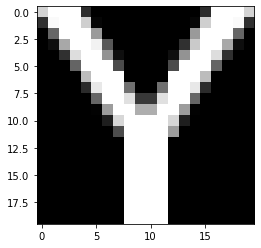

In [12]:
plt.imshow(sample[0], cmap='gray')

# Convert Dataframe to Data

In [33]:
X, Y = np.array(df_labelled.iloc[:, -400:], dtype=np.float64), np.array(df_labelled.loc[:, 'm_label'], dtype=np.int64)

In [34]:
X.shape, Y.shape

((331390, 400), (331390,))

In [35]:
Y[Y<58] -= 48
Y[Y>96] -= 61
Y[Y>64] -= 55

# Fix Data Distribution

In [16]:
(unq_labels, unq_counts) = np.unique(Y, return_counts=True)

<BarContainer object of 62 artists>

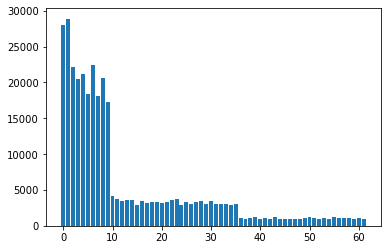

In [17]:
plt.bar(unq_labels, unq_counts)

# Resample Data

In [36]:
from sklearn.utils import resample

In [37]:
X_res, Y_res = resample(X,Y,n_samples=1000)

In [38]:
X_res.shape, Y_res.shape

((1000, 400), (1000,))

In [39]:
(unq_labels_res, unq_counts_res) = np.unique(Y_res, return_counts=True)

<BarContainer object of 58 artists>

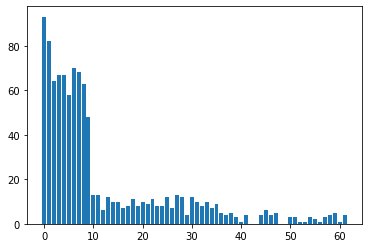

In [40]:
plt.bar(unq_labels_res, unq_counts_res)

# Split Data

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X, Y)
m_train = x_train.shape[0]
m_test = x_test.shape[0]
x_train = np.reshape(x_train, (m_train,20,20,1))
x_test = np.reshape(x_test, (m_test,20,20,1))

In [23]:
x_train.shape, x_test.shape

((93000, 20, 20, 1), (31000, 20, 20, 1))

# Model

In [24]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [25]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    fill_mode="nearest"
)
# aug.fit(x_train)

In [26]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(20, 20, 1)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(250, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(len(unq_labels)),
    keras.layers.Dense(len(unq_labels), activation='softmax')
])

In [27]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy','f1'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 400)               0         
                                                                 
 batch_normalization (BatchN  (None, 400)              1600      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 250)               100250    
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 dense_1 (Dense)             (None, 62)                15562     
                                                                 
 dense_2 (Dense)             (None, 62)                3906      
                                                        

In [30]:
model.fit(aug.flow(x_train, y_train), epochs=5)

Epoch 1/5


TypeError: 'NoneType' object is not callable

In [ ]:
model.evaluate(aug.flow(x_test, y_test, batch_size=BS))

# Test Other Images

In [ ]:
images = []
for path in glob.glob('./datasets/tests/*.jpg'):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, image = cv2.threshold(image ,0 ,255,cv2.THRESH_OTSU)
    image = cv2.resize(image, (20,20))
    images.append(image)

In [ ]:
images = np.array(images)
images = np.reshape(images, (images.shape[0], 20,20,1))

In [ ]:
predictions = model.predict(images)
predictions.shape

In [ ]:
final_pred = np.argmax(predictions, axis=1)
final_pred

In [ ]:
for i in range(images.shape[0]):
    plt.matshow(images[i], cmap='gray')
    plt.title(final_pred[i])

# Save Model

In [ ]:
prob_model.save('./models/character-recognition-update')